In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt
import math
import tqdm

pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
async_folder = "logs/11_H"
sync_folder = "logs/12_I"

experiment_phases = [0, 600_000, 1_200_000, 1_800_000]
function_colors = {
    "check": "blue",
    "virus": "orange",
    "ocr": "green",
    "email": "red",
    "urgentcheck": "blue",
    "urgentvirus": "orange",
    "urgentocr": "green",
    "urgentemail": "red"
}
cpu_color = "black"


In [ ]:

overall_min_unix_time = 9223372036854775807 # Too big, please don't run after Tue Oct 07 4892 21:52:48 GMT+0000
overall_max_unix_time = 0 # Please don't run this experiment before Thu Jan 01 1970 00:00:00 GMT+0000
def get_df_from_folder(folder):
    global overall_min_unix_time
    global overall_max_unix_time
    lines = []
    k6_durations = []
    for file_name in glob.glob("*.log", root_dir=folder):
        with open(folder + "/" + file_name) as f:
            while line := f.readline():
                if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                    json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                    try:
                        lines.append(json.loads(json_string))
                    except:
                        print("Error in file: " + file_name)
                        print("Line: " + line)
                        print("JSON: " + json_string)
                        print("-----")
                        continue
                if "K6MAGICSTRING" in line:
                    raw_data = re.search(r'K6MAGICSTRING(.*?)K7MAGICSTRING', line).group(1)
                    splits = raw_data.split(",")
                    k6_durations.append({
                        "start_unix": float(splits[0]),
                        "req_duration": float(splits[1]),
                        "callid": splits[2]
                    })


    df = pd.DataFrame(lines)
    # Convert type to float
    df["start"] = df["start"].astype(float)
    df["end"] = df["end"].astype(float)
    df["request_timestamp"] = df["request_timestamp"].astype(float)
    df["request_deadline"] = df["request_deadline"].astype(float)


    # Calculate Durations
    cut_off_after_cpu_load = True
    if cut_off_after_cpu_load:
        max_start_time = df["start"] + experiment_phases[3]
        df = df[df["start"] < max_start_time]

    overall_max_unix_time = max(overall_max_unix_time, df["end"].max())
    
    # get k6 data as well
    k6_df = pd.DataFrame(k6_durations)

    exp_min_unix_time = k6_df["start_unix"].min()
    overall_min_unix_time = min(overall_min_unix_time, exp_min_unix_time)
    
    k6_df["req_duration_td"] = pd.to_timedelta(k6_df["req_duration"], unit="ms")
    k6_df["start_rel"] = pd.to_datetime(k6_df["start_unix"] - exp_min_unix_time, unit="ms")
    k6_df["end_rel"] = k6_df["start_rel"] + k6_df["req_duration_td"]


    df["request_timestamp_rel"] = pd.to_datetime(df["request_timestamp"] - overall_min_unix_time, unit="ms")
    df["request_deadline_rel"] = pd.to_datetime(df["request_deadline"] - overall_min_unix_time, unit="ms")
    df["start_rel"] = pd.to_datetime(df["start"] - overall_min_unix_time, unit="ms")
    df["end_rel"] = pd.to_datetime(df["end"] - overall_min_unix_time, unit="ms")

    # Set Correct Data Types
    df["start_dt"] = pd.to_datetime(df["start"], unit="ms")
    df["end_dt"] = pd.to_datetime(df["end"], unit="ms")
    df["request_timestamp_dt"] = pd.to_datetime(df["request_timestamp"], unit="ms")
    df["request_deadline_dt"] = pd.to_datetime(df["request_deadline"], unit="ms")

    # Add new columns
    df["run_duration"] = df["end"] - df["start"]
    df["time_to_deadline"] = df["request_deadline"] - df["start"]
    df["init_duration"] = df["start"] - df["request_timestamp"]
    df = df.sort_values(by=["function", "start"])
    df["__start_diff"] = df.groupby("function")["start"].diff()
    df['line_segment'] = (df['__start_diff'] > 5000).cumsum() # create a new line segment if there is a 5 second break

    return (df, k6_df, exp_min_unix_time)

(sync_df, sync_k6_df, sync_min_unix) = get_df_from_folder(sync_folder)
(async_df, async_k6_df, async_min_unix) = get_df_from_folder(async_folder)
sync_df = sync_df[sync_df["function"].str.contains("urgent", regex=False)]
sync_df["experiment"] = "sync"
async_df["experiment"] = "async"
df = pd.concat([sync_df, async_df])
sync_k6_df["experiment"] = "sync"
async_k6_df["experiment"] = "async"
k6_df = pd.concat([sync_k6_df, async_k6_df])


IndexError: list index out of range

sync:  25%|██▍       | 449/1801 [00:20<01:29, 15.12it/s]

In [ ]:
print(f"Sync experiment started on {pd.to_datetime(sync_min_unix, unit='ms')} and ended on {pd.to_datetime(sync_df['end'].max(), unit='ms')}")
print(f"Async experiment started on {pd.to_datetime(async_min_unix, unit='ms')} and ended on {pd.to_datetime(async_df['end'].max(), unit='ms')}")

Sync experiment started on 2023-09-19 14:47:29.748000 and ended on 2023-09-19 15:39:10.576678912
Async experiment started on 2023-09-19 15:46:47.841999872 and ended on 2023-09-19 16:20:28.822068480


In [14]:
# If you want all CPU usage values in the df set this to False
ONLY_RELEVANT_CPU = True

__smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    # if ONLY_RELEVANT_CPU:
    #     start_ts = int(file_name.split("_")[3].split(".")[0])
    #     if start_ts > last_experiment_timestamp or start_ts < min_timestamp - 1000*60*60*24:
    #         continue
    with open("usage/" + file_name) as f:
        __smaller_dfs.append(pd.read_csv(f))
usage_df = pd.concat(__smaller_dfs)
usage_df["unix_time_dt"] = pd.to_datetime(usage_df["unix_time"], unit="ms")
# usage_df["experiment_time"] = usage_df["unix_time"] - min_timestamp

# if ONLY_RELEVANT_CPU:
#     # Delete all values 10 seconds after the last call ended and 10 seconds before the first call started
#     print("removed before:" + str(len(usage_df[usage_df["unix_time"] <= (last_experiment_timestamp)])))
#     usage_df = usage_df[usage_df["unix_time"] <= (last_experiment_timestamp)]
#     print("removed after:" + str(len(usage_df[usage_df["unix_time"] >= (min_timestamp)])))
#     usage_df = usage_df[usage_df["unix_time"] >= (min_timestamp)]

async_usage_df = usage_df[(usage_df["unix_time"] > async_min_unix) & (usage_df["unix_time"] < async_df["end"].max())]
async_usage_df["experiment_time_rel"] = pd.to_datetime(async_usage_df["unix_time"] - async_min_unix, unit="ms")
async_usage_df["experiment"] = "async"
sync_usage_df = usage_df[(usage_df["unix_time"] > sync_min_unix) & (usage_df["unix_time"] < sync_df["end"].max())]
sync_usage_df["experiment_time_rel"] = pd.to_datetime(sync_usage_df["unix_time"] - sync_min_unix, unit="ms")
sync_usage_df["experiment"] = "sync"
usage_df = pd.concat([async_usage_df, sync_usage_df])

In [15]:
print(f"Sync usage goes from {sync_usage_df['unix_time_dt'].min()} and ended on {sync_usage_df['unix_time_dt'].max()}")
print(f"Async usage goes from {async_usage_df['unix_time_dt'].min()} and ended on {async_usage_df['unix_time_dt'].max()}")

Sync usage goes from 2023-09-19 14:49:25.104000 and ended on 2023-09-19 15:07:08.905000
Async usage goes from 2023-09-19 15:46:48.032000 and ended on 2023-09-19 16:20:27.530000


In [ ]:
test = usage_df[(usage_df["unix_time_dt"] > pd.to_datetime("2023-09-19 14:49:25.104000")) & (usage_df["unix_time_dt"] < pd.to_datetime("2023-09-19 15:39:10.576678912"))]
test["unix_time_dt"].max()

Timestamp('2023-09-19 15:07:08.905000')

In [ ]:
def get_workflow_from_df(df, k6_df, experiment):
    df = df.copy()
    df["__arbitrary_start"] = df["request_timestamp_rel"]
    df["__arbitrary_start"].fillna(df["start_rel"])
    df["total_run_duration"] = df["end_rel"] - df["__arbitrary_start"]
    df["total_run_duration_td"] = pd.to_timedelta(df["total_run_duration"], unit="ms")
    worfklow_list = []

    # for id in df["callid"].unique():
    #     workflow_info = {
    #         'start_rel': df[df["callid"] == id]["start_rel"].min(),
    #         'end_rel': df[df["callid"] == id]["end_rel"].max(),
    #         'num_swamped': len(df[(df["callid"] == id) & df["mode"] == "swamped"]),
    #         'run_duration': df[df["callid"] == id]["run_duration"].sum(),
    #         'total_run_duration_td': df[df["callid"] == id]["total_run_duration_td"].sum(),
    #         'request_sent_rel': k6_df[k6_df["callid"] == id]["start_rel"].min(), # its only one value, but who counts anyway
    #         'request_duration_rel': k6_df[k6_df["callid"] == id]["req_duration_td"].sum(), # also only one value
    #     }
    #     worfklow_list.append(workflow_info)

    # repeat above for loop with a loop comprehension
    worfklow_list = [
        {
            'start_rel': df[df["callid"] == id]["start_rel"].min(),
            'end_rel': df[df["callid"] == id]["end_rel"].max(),
            'num_swamped': len(df[(df["callid"] == id) & df["mode"] == "swamped"]),
            'run_duration': df[df["callid"] == id]["run_duration"].sum(),
            'total_run_duration_td': df[df["callid"] == id]["total_run_duration_td"].sum(),
            'request_sent_rel': k6_df[k6_df["callid"] == id]["start_rel"].min(), # its only one value, but who counts anyway
            'request_duration_rel': k6_df[k6_df["callid"] == id]["req_duration_td"].sum(), # also only one value
            'experiment': experiment
        }
        for id in tqdm.tqdm(df["callid"].unique(), desc=df["experiment"].iloc[0])
    ]

    return pd.DataFrame(worfklow_list)
sync_workflow_df = get_workflow_from_df(sync_df, sync_k6_df, "sync")
async_workflow_df = get_workflow_from_df(async_df, async_k6_df, "async")
workflow_df = pd.concat([sync_workflow_df, async_workflow_df])

sync:  25%|██▍       | 449/1801 [00:08<01:29, 15.12it/s] 

KeyboardInterrupt: 

In [ ]:
sync_usage_df

,unix_time,cpu_percent,ram_percent,unix_time_dt,experiment_time_rel,experiment
0,1695134965104,13.10,18.92,2023-09-19 14:49:25.104,1970-01-01 00:01:55.356,sync
1,1695134967116,26.05,18.99,2023-09-19 14:49:27.116,1970-01-01 00:01:57.368,sync
2,1695134969132,94.21,19.09,2023-09-19 14:49:29.132,1970-01-01 00:01:59.384,sync
3,1695134971162,93.54,19.05,2023-09-19 14:49:31.162,1970-01-01 00:02:01.414,sync
4,1695134973181,91.85,19.02,2023-09-19 14:49:33.181,1970-01-01 00:02:03.433,sync
...,...,...,...,...,...,...
1000,1695140429547,29.16,21.96,2023-09-19 16:20:29.547,1970-01-01 01:32:59.799,sync
1001,1695140431559,26.65,21.98,2023-09-19 16:20:31.559,1970-01-01 01:33:01.811,sync
1002,1695140433597,32.17,21.96,2023-09-19 16:20:33.597,1970-01-01 01:33:03.849,sync
1003,1695140435609,24.60,21.98,2023-09-19 16:20:35.609,1970-01-01 01:33:05.861,sync


In [ ]:
sync_usage_rolling_df = sync_usage_df[["experiment_time_rel", "cpu_percent", "ram_percent"]].rolling("60s", on="experiment_time_rel").mean()
sync_usage_rolling_df["experiment"] = "sync"
async_usage_rolling_df = async_usage_df[["experiment_time_rel", "cpu_percent", "ram_percent"]].rolling("60s", on="experiment_time_rel").mean()
async_usage_rolling_df["experiment"] = "async"
usage_rolling_df = pd.concat([sync_usage_rolling_df, async_usage_rolling_df])

<Axes: xlabel='experiment_time_rel', ylabel='cpu_percent'>

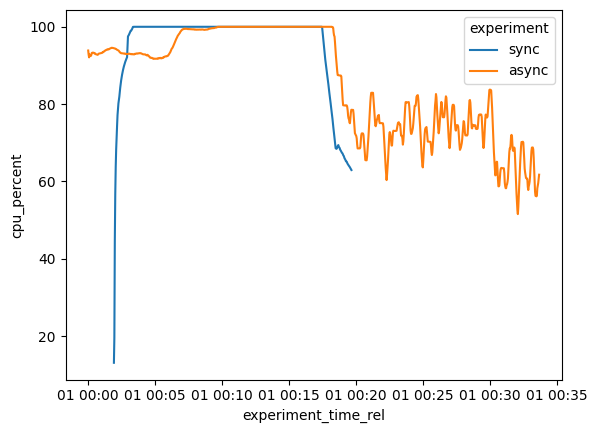

In [ ]:
sns.lineplot(usage_rolling_df, x="experiment_time_rel", y="cpu_percent", hue="experiment")

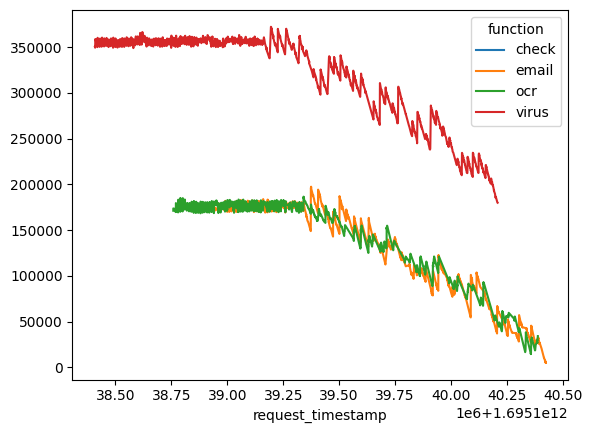

<Axes: xlabel='request_timestamp'>

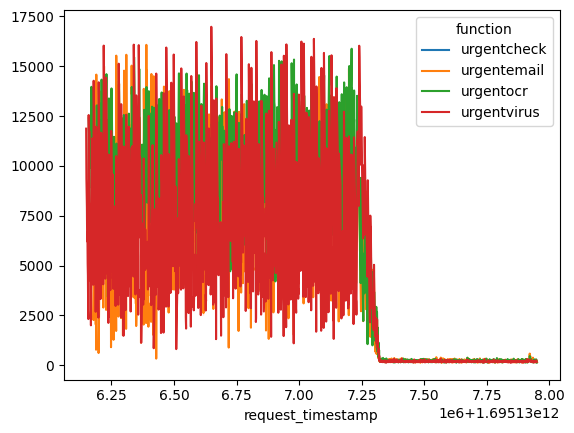

In [ ]:
sns.lineplot(data=async_df, x="request_timestamp", y=async_df["start"]-async_df["request_timestamp"], hue="function")
plt.show()
sns.lineplot(data=sync_df, x="request_timestamp", y=sync_df["start"]-sync_df["request_timestamp"], hue="function")

In [ ]:

# for (function, segment), group in tqdm.tqdm(sync_df.groupby(["function", "line_segment"])):
#     sns.lineplot(data=group, x="start_rel", y="run_duration", color=function_colors[function], errorbar="ci", label=function, legend="brief")
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
# ax2 = plt.twinx()
# sns.lineplot(sync_usage_rolling_df, x="experiment_time_rel", y="cpu_percent")

KeyboardInterrupt: 

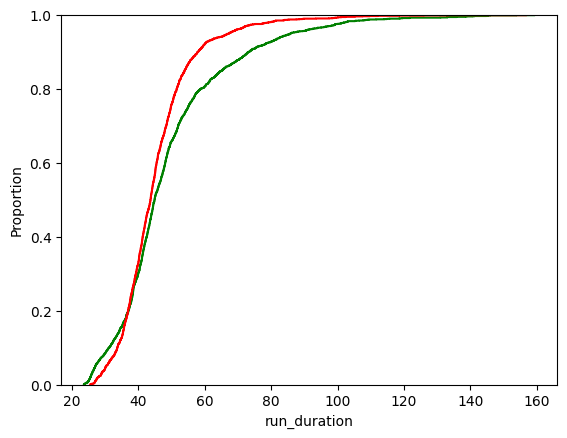

<Axes: xlabel='run_duration', ylabel='Proportion'>

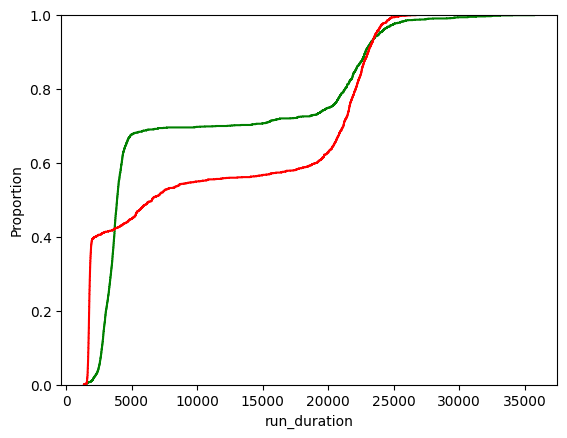

In [ ]:
sns.ecdfplot(data=async_df[async_df["function"] == "check"], x="run_duration", color="green", label="Async")
sns.ecdfplot(data=sync_df[sync_df["function"] == "urgentcheck"], x="run_duration", color="red", label="Sync")
plt.show()
sns.ecdfplot(data=async_df[async_df["function"] == "ocr"], x="run_duration", color="green", label="Async")
sns.ecdfplot(data=sync_df[sync_df["function"] == "urgentocr"], x="run_duration", color="red", label="Sync")

<Axes: >

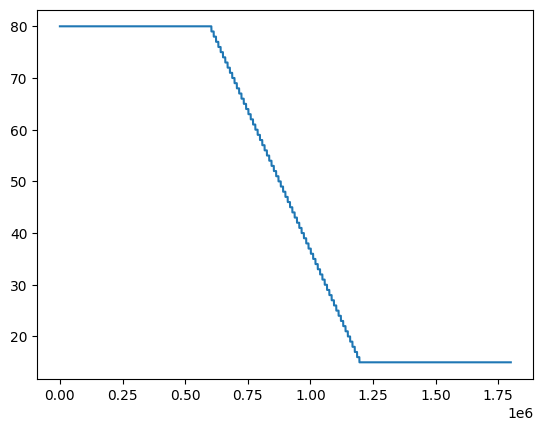

In [ ]:
def get_cpu_share(start, end, current):
    # get the length of the experiment
    length = end - start
    # get the current time in the experiment
    current = current - start

    # if the current time is in the first third of the experiment
    if current < length/3:
        return "0.80"
    # if the current time is in the last third of the experiment
    elif current > 2*length/3:
        return "0.15"
    # if the current time is in the middle third of the experiment
    else:
        # calculate the cpu share based on the current time
        return str(round(((-1.95/length)*current + 1.45), 2))
        # the value if you want to go from 50 to 15:
        # return str(round(((-105/length)*current + 85)/100, 2))

artificial_cpu_load = [float(get_cpu_share(0, experiment_phases[3], i)) * 100 for i in range(0, experiment_phases[3])]
art_cpu_df = pd.DataFrame([{'load_percent': i, 'experiment_time': idx, 'experiment_time_rel': pd.to_datetime(idx, unit="ms")} for idx, i in enumerate(artificial_cpu_load]))
sns.lineplot(artificial_cpu_load)

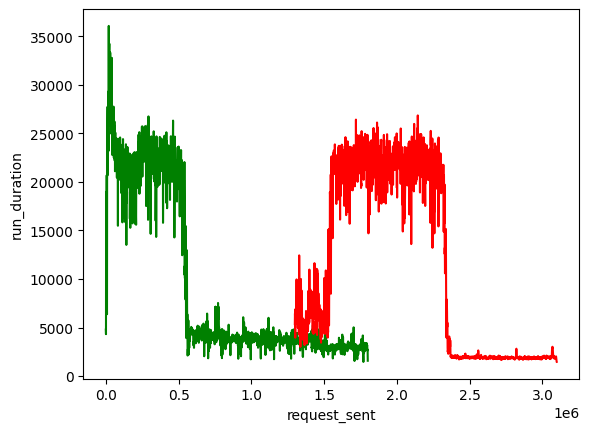

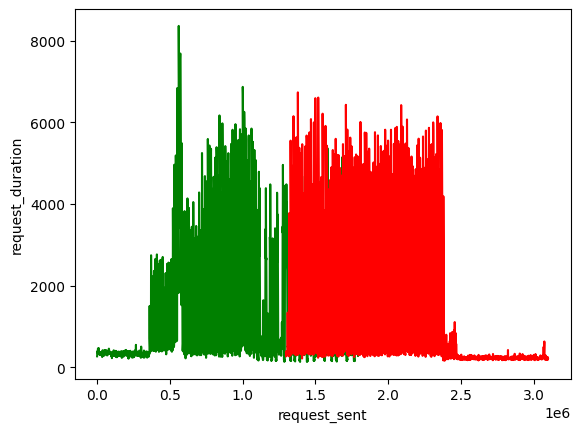

<Axes: xlabel='request_duration', ylabel='Proportion'>

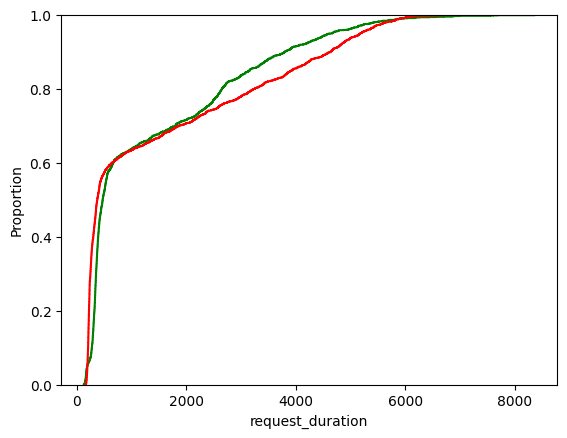

In [ ]:
sns.lineplot(data=async_workflow_df, x="request_sent_rel", y="run_duration", color="green")
sns.lineplot(data=sync_workflow_df, x="request_sent_rel", y="run_duration", color="red")
plt.show()
sns.lineplot(data=async_workflow_df, x="request_sent_rel", y="request_duration", color="green")
sns.lineplot(data=sync_workflow_df, x="request_sent_rel", y="request_duration", color="red")
plt.show()
sns.ecdfplot(data=async_workflow_df, x="request_duration", color="green")
sns.ecdfplot(data=sync_workflow_df, x="request_duration", color="red")

In [ ]:
async_concurrent_requests = [(len(async_df[(async_df["start"] <= i) & (async_df["end"] >= i)])) for i in tqdm.trange(int(async_df["start"].min()), int(async_df["end"].max()), 10_000)]
sync_concurrent_requests = [(len(sync_df[(sync_df["start"] <= i) & (sync_df["end"] >= i)])) for i in tqdm.trange(int(sync_df["start"].min()), int(sync_df["end"].max()), 10_000)]

100%|██████████| 181/181 [00:00<00:00, 5240.20it/s]


<Axes: >

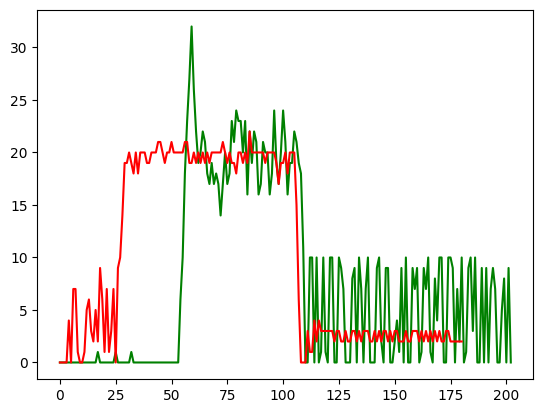

In [ ]:
sns.lineplot(async_concurrent_requests, color="green")
sns.lineplot(sync_concurrent_requests, color="red")

# Actual Paper Grpfash

NameError: name 'artificial_cpu_load' is not defined

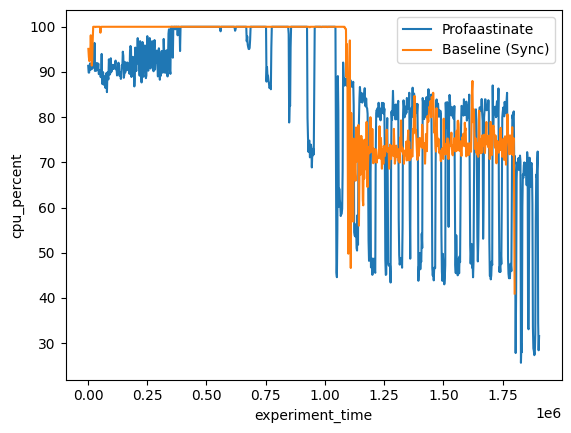

In [ ]:
sns.lineplot(async_usage_rolling_df, x="experiment_time_rel", y="cpu_percent", label="Profaastinate")
sns.lineplot(sync_usage_rolling_df, x="experiment_time_rel", y="cpu_percent", label="Baseline (Sync)")
sns.lineplot(data=artificial_cpu_load, label="Base CPU Load")
plt.ylim(0, 110)
plt.xlim(0, experiment_phases[3])
plt.ylabel("CPU Usage (%)")
plt.xlabel("Experiment Time (ms)")